In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import shapiro
import statsmodels.api as sm

In [4]:
mfile = pd.read_csv('mfile_1.csv')
mfile.head()

,회원번호,조합원상태,주소,성별,연령,배송서비스신청여부,모바일알람여부,Gold_member,연령대
0,1000012800,정상회원,수지구-풍덕천동,여,58.0,미신청,.,normal,50대
1,1000103744,정상회원,처인구-고림동,여,34.0,미신청,.,normal,30대
2,1000122304,정상회원,광주-기타,여,38.0,미신청,.,normal,30대
3,1000163136,정상회원,수지구-동천동,여,73.0,미신청,.,normal,60대이상
4,1000281920,정상회원,수지구-풍덕천동,여,42.0,신청,.,normal,40대


In [5]:
dt_A = pd.read_csv('dt_A.csv')
dt_B = pd.read_csv('dt_B.csv')
dt_C = pd.read_csv('dt_C.csv')
dt_D = pd.read_csv('dt_D.csv')

In [6]:
dt_A

,공급일자,회원번호,조합원상태,물품대분류,물품중분류,물품소분류,물품명,구매수량,구매금액,구매매장,반품_원거래일자,구매시각,월,요일
0,2018-01-02,220954944,정상회원,반찬,두부/유부,두부,두부(1모:420g),1.0,3829,매장A,NaN,10:32,1,화
1,2018-01-02,89023040,정상회원,채소,열매채소,단호박/손질,단호박(깍뚝썰기/300g),1.0,4977,매장A,NaN,10:41,1,화
2,2018-01-02,354941440,정상회원,축산물,알,유정란,유정란/매장용(10알/국내산),1.0,7083,매장A,NaN,11:00,1,화
3,2018-01-02,786634048,탈퇴,반찬,어묵/묵,묵,도토리묵(420g:1모),1.0,7083,매장A,NaN,11:28,1,화
4,2018-01-02,438543104,정상회원,축산물,알,유정란,유정란/매장용(10알/국내산),1.0,7083,매장A,NaN,11:59,1,화
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52554,2018-10-31,1110819712,정상회원,채소,뿌리채소,무,무(0.7~1kg미만),1.0,2680,매장A,NaN,13:26,10,수
52555,2018-10-31,1517953728,정상회원,채소,양념채소,쪽파,쪽파(500g),1.0,4212,매장A,NaN,10:58,10,수
52556,2018-10-31,713691392,정상회원,반찬,밑반찬,조림,우엉조림(반찬용/150g),1.0,7658,매장A,NaN,14:36,10,수
52557,2018-10-31,247926336,정상회원,간식,빵,건강곡물빵,감자바게트(180g)/매장,1.0,5169,매장A,NaN,16:23,10,수


In [ ]:
visit_rate = dt_A[['공급일자','회원번호','구매시각']]
visit_rate.head()
visit_rate['시'] = 0
# 구매시각에서 시간만 추출
for i in range(len(visit_rate)):
    visit_rate['시'][i] = int(visit_rate['구매시각'][i].split(':')[0])
# visit_rate['시'].value_counts()
# 공급일자, 회원번호, 시가 같은 중복행 제거하고 유일값만 남김
visit_rate.drop('구매시각', axis = 1, inplace = True)
unique_visit_rate = visit_rate.drop_duplicates()
unique_visit_rate.reset_index(inplace = True)
# 오전, 오후, 저녁방문여부 더미변수 생성
unique_visit_rate['오전방문'] = 0
unique_visit_rate['오후방문'] = 0
unique_visit_rate['저녁방문'] = 0
unique_visit_rate.loc[unique_visit_rate['시'] < 12, '오전방문'] = 1
unique_visit_rate.loc[(unique_visit_rate['시'] >= 12) & (unique_visit_rate['시'] < 17), '오후방문'] = 1
unique_visit_rate.loc[unique_visit_rate['시'] >= 17, '저녁방문'] = 1
# 오전오후저녁 변수 생성
unique_visit_rate['오전오후저녁'] = ''
unique_visit_rate.loc[unique_visit_rate['시'] < 12, '오전오후저녁'] = '오전'
unique_visit_rate.loc[(unique_visit_rate['시'] >= 12) & (unique_visit_rate['시'] < 17), '오전오후저녁'] = '오후'
unique_visit_rate.loc[unique_visit_rate['시'] >= 17, '오전오후저녁'] = '저녁'
# 회원번호의 오전, 오후, 저녁별 방문수 count
u = unique_visit_rate.groupby(['회원번호','오전오후저녁'])['오전오후저녁'].count()
u_stack = u.unstack()
u_stack.fillna(0, inplace= True)
# 한 지점의 회원별 총방문수와 오전, 오후, 저녁 방문율 계산
u_stack['총방문수'] = u_stack['오전'] + u_stack['오후'] + u_stack['저녁']
u_stack['오전방문율'] = round(u_stack['오전'] / u_stack['총방문수'],2)
u_stack['오후방문율'] = round(u_stack['오후'] / u_stack['총방문수'],2)
u_stack['저녁방문율'] = round(u_stack['저녁'] / u_stack['총방문수'],2)
u_stack.to_csv('dtA_visit_rate.csv', encoding = 'utf-8')

In [37]:
visit_count = dt_A[['공급일자','회원번호','요일','구매시각']]
visit_count['시'] = 0
for i in range(len(visit_count)):
    visit_count['시'][i] = visit_count.구매시각[i].split(':')[0]

visit_count.drop('구매시각', axis = 1, inplace = True)

unique_visit_count = visit_count.drop_duplicates()
unique_visit_count.reset_index(drop = True, inplace = True)
unique_visit_count
# dt_A.groupby(['회원번호','요일'])['구매금액'].count()

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,공급일자,회원번호,요일,시
0,2018-01-02,220954944,화,10
1,2018-01-02,89023040,화,10
2,2018-01-02,354941440,화,11
3,2018-01-02,786634048,화,11
4,2018-01-02,438543104,화,11
...,...,...,...,...
25258,2018-10-31,1009040384,수,16
25259,2018-10-31,1171624128,수,14
25260,2018-10-31,86983296,수,18
25261,2018-10-31,1517953728,수,10


In [17]:
A_weekday = dt_A.groupby(['회원번호','요일'])['구매금액'].sum().unstack().fillna(0)
A_weekday

요일,금,목,수,월,일,토,화
회원번호,,,,,,,
18764160,21059.0,0.0,0.0,0.0,0.0,0.0,0.0
20235968,0.0,86531.0,0.0,7275.0,0.0,68154.0,2489.0
20258240,3063.0,0.0,0.0,0.0,0.0,0.0,0.0
20588608,327903.0,440606.0,304869.0,348233.0,97442.0,936349.0,205898.0
22259008,4595.0,88637.0,14358.0,26993.0,0.0,0.0,62792.0
...,...,...,...,...,...,...,...
1640241856,0.0,0.0,0.0,0.0,0.0,9858.0,0.0
1640596352,0.0,0.0,0.0,2106.0,0.0,0.0,31301.0
1640913728,0.0,0.0,0.0,16004.0,0.0,0.0,0.0


In [25]:
A_weekday_sum = A_weekday.apply(sum, axis = 0)
A_weekday_sum

요일
금     87400879.0
목     78953015.0
수     87816954.0
월    111218796.0
일     48258889.0
토     82467206.0
화     87431393.0
dtype: float64

In [26]:
B_weekday = dt_B.groupby(['회원번호','요일'])['구매금액'].sum().unstack().fillna(0)
B_weekday_sum=B_weekday.apply(sum, axis = 0)
B_weekday_sum

요일
금    110834387.0
목    102180895.0
수    102265921.0
월    132869819.0
일     55883108.0
토    103760088.0
화    106972582.0
dtype: float64

In [27]:
C_weekday = dt_C.groupby(['회원번호','요일'])['구매금액'].sum().unstack().fillna(0)
C_weekday_sum=C_weekday.apply(sum, axis = 0)
C_weekday_sum

요일
금    200729389.0
목    190855719.0
수    195186251.0
월    236368028.0
일    102058088.0
토    196514701.0
화    208326743.0
dtype: float64

In [28]:
D_weekday = dt_D.groupby(['회원번호','요일'])['구매금액'].sum().unstack().fillna(0)
D_weekday_sum=D_weekday.apply(sum, axis = 0)
D_weekday_sum

요일
금     97020923.0
목    105450858.0
수     92818834.0
월    102359287.0
일     47777029.0
토     92929389.0
화     88459696.0
dtype: float64

## 월별 1인당 구매력

In [27]:
dt_A_month = dt_A.pivot_table(index = '회원번호', columns = '월', values = '구매금액',aggfunc = 'sum', margins = True).reset_index()
dt_A_month

월,회원번호,1,2,3,4,5,6,7,8,9,10,All
0,18764160,8806.0,NaN,21059.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29865.0
1,20235968,14359.0,35225.0,16273.0,NaN,NaN,NaN,NaN,2489.0,10721.0,85382.0,164449.0
2,20258240,NaN,NaN,NaN,NaN,3063.0,NaN,NaN,NaN,NaN,NaN,3063.0
3,20588608,127596.0,277972.0,200537.0,205227.0,185411.0,267349.0,341592.0,366231.0,518714.0,236719.0,2727348.0
4,22259008,NaN,NaN,56475.0,NaN,14933.0,NaN,59155.0,NaN,NaN,66812.0,197375.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2627,1640596352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33407.0,33407.0
2628,1640913728,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16004.0,16004.0
2629,1644557056,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27951.0,27951.0
2630,1670400000,258496.0,104451.0,154704.0,468896.0,164067.0,176797.0,162918.0,469987.0,90377.0,171338.0,2222031.0


In [28]:
dt_A_month_mean = dt_A.pivot_table(index = '회원번호', columns = '월', values = '구매금액',aggfunc = 'sum', margins = True)/(len(dt_A_month)-1 -dt_A_month.isnull().sum())
dt_A_month_mean

월,1,2,3,4,5,6,7,8,9,10,All,회원번호
회원번호,,,,,,,,,,,,
18764160,8.237605,NaN,19.427122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.351197,NaN
20235968,13.432180,35.366466,15.011993,NaN,NaN,NaN,NaN,2.501508,10.614851,86.331648,62.504371,NaN
20258240,NaN,NaN,NaN,NaN,2.948027,NaN,NaN,NaN,NaN,NaN,1.164196,NaN
20588608,119.360150,279.088353,184.997232,198.670862,178.451396,267.616617,331.965015,368.071357,513.578218,239.351871,1036.620296,NaN
22259008,NaN,NaN,52.098708,NaN,14.372474,NaN,57.487852,NaN,NaN,67.555106,75.019004,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1640596352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.778564,12.697453,NaN
1640913728,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.182002,6.082858,NaN
1644557056,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.261881,10.623717,NaN


In [29]:
A_m_mean = dt_A_month_mean.iloc[-1]

In [30]:
dt_B_month = dt_B.pivot_table(index = '회원번호', columns = '월', values = '구매금액',aggfunc = 'sum', margins = True).reset_index()
dt_B_month_mean = dt_B.pivot_table(index = '회원번호', columns = '월', values = '구매금액',aggfunc = 'sum', margins = True)/(len(dt_B_month)-1 -dt_B_month.isnull().sum())
B_m_mean = dt_B_month_mean.iloc[-1]

In [31]:
dt_C_month = dt_C.pivot_table(index = '회원번호', columns = '월', values = '구매금액',aggfunc = 'sum', margins = True).reset_index()
dt_C_month_mean = dt_C.pivot_table(index = '회원번호', columns = '월', values = '구매금액',aggfunc = 'sum', margins = True)/(len(dt_C_month)-1 -dt_C_month.isnull().sum())
C_m_mean = dt_C_month_mean.iloc[-1]

In [32]:
dt_D_month = dt_D.pivot_table(index = '회원번호', columns = '월', values = '구매금액',aggfunc = 'sum', margins = True).reset_index()
dt_D_month_mean = dt_D.pivot_table(index = '회원번호', columns = '월', values = '구매금액',aggfunc = 'sum', margins = True)/(len(dt_D_month)-1 -dt_D_month.isnull().sum())
D_m_mean = dt_D_month_mean.iloc[-1]

In [33]:
f_result=stats.f_oneway(A_m_mean[:10],B_m_mean[:10],C_m_mean[:10],D_m_mean[:10])
f,p=f_result.statistic.round(3),f_result.pvalue.round(3)
print("One way ANOVA test")
print("F통계량:{}".format(f))
print("p-value:{}".format(p))

One way ANOVA test
F통계량:5.261
p-value:0.004


In [34]:
abcd_m_mean = pd.DataFrame({'A' : A_m_mean[:10], 'B' : B_m_mean[:10],'C' : C_m_mean[:10],'D': D_m_mean[:10]})
abcd_m_mean

,A,B,C,D
월,,,,
1,59584.853134,53853.378855,54901.885933,54951.628360
2,58715.110442,55183.440804,58128.197582,66132.302013
3,54065.832103,49385.443159,53209.965585,57402.197487
4,51605.871249,48353.252343,52438.521133,55327.750958
5,53635.161694,50241.259676,54670.944285,56463.022079
6,53971.156156,50584.749647,53307.778132,56248.976437
7,71657.502430,59735.232740,56189.869101,60351.151571
8,55186.697487,50285.893522,57759.375359,64159.234117
9,63841.664356,53219.402282,55073.727044,64650.790909


Text(0.5, 1.0, '지점별 1인당 구매력')

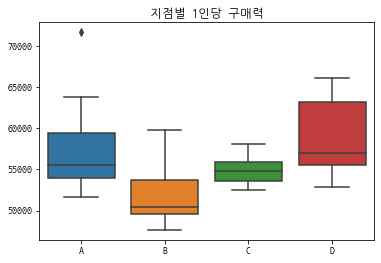

In [35]:
sns.boxplot(data = abcd_m_mean)
plt.title("지점별 1인당 구매력")

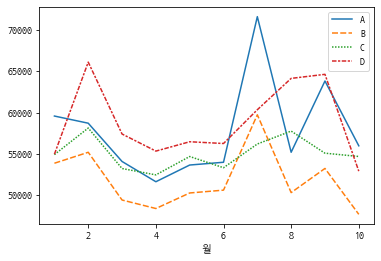

In [36]:
sns.lineplot(data = abcd_m_mean)

In [37]:
A = pd.DataFrame({'maket' : A_m_mean[:10]}).reset_index()
A['매장']= 'A'
B = pd.DataFrame({'maket' : B_m_mean[:10]}).reset_index()
C = pd.DataFrame({'maket' : C_m_mean[:10]}).reset_index()
D = pd.DataFrame({'maket' : D_m_mean[:10]}).reset_index()
B['매장']= 'B'
C['매장']= 'C'
D['매장']= 'D'

A2 = pd.concat([A,B])
A3 = pd.concat([A2,C])
p1 = pd.concat([A3,D])
p1

,월,maket,매장
0,1,59584.853134,A
1,2,58715.110442,A
2,3,54065.832103,A
3,4,51605.871249,A
4,5,53635.161694,A
5,6,53971.156156,A
6,7,71657.502430,A
7,8,55186.697487,A
8,9,63841.664356,A
9,10,55970.510617,A


In [38]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

posthoc = pairwise_tukeyhsd(p1['maket'].astype('float64'), p1['매장'], alpha=0.05)
print(posthoc)

     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1 group2  meandiff  p-adj     lower      upper    reject
-------------------------------------------------------------
     A      B -5974.4551 0.0195 -11190.9305  -757.9798   True
     A      C -2788.0235 0.4844  -8004.4989  2428.4519  False
     A      D   1034.458    0.9  -4182.0174  6250.9333  False
     B      C  3186.4316 0.3678  -2030.0438   8402.907  False
     B      D  7008.9131 0.0048   1792.4377 12225.3885   True
     C      D  3822.4815 0.2169  -1393.9939  9038.9568  False
-------------------------------------------------------------


## 월별 1회 방문시 구매력

In [39]:
dt_A_month_freq = dt_A.pivot_table(index = ['회원번호','공급일자','월'], values = '구매금액',aggfunc = 'sum').reset_index()
dt_A_month_freq['label'] = 1
dt_A_month_freq_1 = dt_A_month_freq.pivot_table(index = ['회원번호'],columns = '월', values = 'label',aggfunc = 'sum', margins = True).reset_index()
A_m_mean_freq = dt_A_month.iloc[-1].values[1:11]/dt_A_month_freq_1.iloc[-1].values[1:11]
A_m_mean_freq

array([24163.963581183612, 26497.621205256004, 22403.425840978594,
       21400.588117222, 22801.527414075288, 22474.858274280952,
       28702.051381860645, 21695.28407743975, 26733.035240464345,
       23141.653428093647], dtype=object)

In [40]:
dt_B_month_freq = dt_B.pivot_table(index = ['회원번호','공급일자','월'], values = '구매금액',aggfunc = 'sum').reset_index()
dt_B_month_freq['label'] = 1
dt_B_month_freq_1 = dt_B_month_freq.pivot_table(index = ['회원번호'],columns = '월', values = 'label',aggfunc = 'sum', margins = True).reset_index()
B_m_mean_freq = dt_B_month.iloc[-1].values[1:11]/dt_B_month_freq_1.iloc[-1].values[1:11]
B_m_mean_freq

array([23389.126913265307, 27377.67306981899, 22356.615100154082,
       21767.595261278806, 22904.340712223293, 22613.23297604035,
       26475.710410094638, 22041.108028720628, 25370.146888813328,
       21865.75081539465], dtype=object)

In [41]:
dt_C_month_freq = dt_C.pivot_table(index = ['회원번호','공급일자','월'], values = '구매금액',aggfunc = 'sum').reset_index()
dt_C_month_freq['label'] = 1
dt_C_month_freq_1 = dt_C_month_freq.pivot_table(index = ['회원번호'],columns = '월', values = 'label',aggfunc = 'sum', margins = True).reset_index()
C_m_mean_freq = dt_C_month.iloc[-1].values[1:11]/dt_C_month_freq_1.iloc[-1].values[1:11]
C_m_mean_freq

array([19766.59106080395, 23226.10692871419, 19368.580705543558,
       19537.177190032104, 19971.831038611195, 19639.7077330197,
       20096.0832110361, 20932.293347224288, 21490.647742146597,
       20121.451322023535], dtype=object)

In [42]:
dt_D_month_freq = dt_D.pivot_table(index = ['회원번호','공급일자','월'], values = '구매금액',aggfunc = 'sum').reset_index()
dt_D_month_freq['label'] = 1
dt_D_month_freq_1 = dt_D_month_freq.pivot_table(index = ['회원번호'],columns = '월', values = 'label',aggfunc = 'sum', margins = True).reset_index()
D_m_mean_freq = dt_D_month.iloc[-1].values[1:11]/dt_D_month_freq_1.iloc[-1].values[1:11]
D_m_mean_freq

array([22848.865895953757, 28326.89568788501, 23244.655761541257,
       22545.734582357534, 22816.09851301115, 22597.5630443014,
       22904.225184145915, 25632.461752433937, 26049.76923076923,
       21714.144048521608], dtype=object)

In [43]:
f_result=stats.f_oneway( A_m_mean_freq, B_m_mean_freq, C_m_mean_freq, D_m_mean_freq)
f,p=f_result.statistic.round(3),f_result.pvalue.round(3)
print("One way ANOVA test")
print("F통계량:{}".format(f))
print("p-value:{}".format(p))

One way ANOVA test
F통계량:7.331
p-value:0.001


In [44]:
abcd_m_mean_freq = pd.DataFrame({'A' : A_m_mean_freq, 'B' : B_m_mean_freq,'C' : C_m_mean_freq,'D': D_m_mean_freq}, index = np.array(range(1,11)))
abcd_m_mean_freq2 = abcd_m_mean_freq.reset_index()

Text(0.5, 1.0, '매장별 1회당 구매력의 월별 추이')

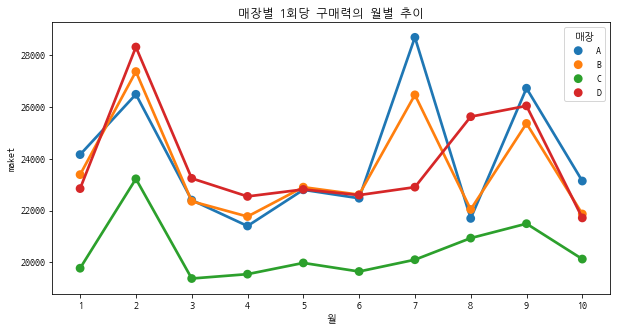

In [45]:
A = pd.DataFrame({'maket' : A_m_mean_freq}).reset_index()
A['매장']= 'A'
B = pd.DataFrame({'maket' : B_m_mean_freq}).reset_index()
C = pd.DataFrame({'maket' : C_m_mean_freq}).reset_index()
D = pd.DataFrame({'maket' : D_m_mean_freq}).reset_index()
B['매장']= 'B'
C['매장']= 'C'
D['매장']= 'D'

A2 = pd.concat([A,B])
A3 = pd.concat([A2,C])
p2 = pd.concat([A3,D])
p2['월']= p2['index']+1

plt.figure(figsize=[10,5])
sns.pointplot(data=p2, x='월',y='maket',hue='매장')
plt.title("매장별 1회당 구매력의 월별 추이")

In [46]:
p2

,index,maket,매장,월
0,0,24164,A,1
1,1,26497.6,A,2
2,2,22403.4,A,3
3,3,21400.6,A,4
4,4,22801.5,A,5
5,5,22474.9,A,6
6,6,28702.1,A,7
7,7,21695.3,A,8
8,8,26733,A,9
9,9,23141.7,A,10


In [47]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

posthoc = pairwise_tukeyhsd(p2['maket'].astype('float64'), p2['매장'], alpha=0.05)
print(posthoc)

    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1 group2  meandiff  p-adj    lower      upper    reject
------------------------------------------------------------
     A      B  -385.2708    0.9 -2796.6408  2026.0991  False
     A      C -3586.3538 0.0016 -5997.7238 -1174.9839   True
     A      D  -133.3595    0.9 -2544.7294  2278.0105  False
     B      C  -3201.083 0.0054 -5612.4529   -789.713   True
     B      D   251.9114    0.9 -2159.4586  2663.2813  False
     C      D  3452.9943 0.0025  1041.6244  5864.3643   True
------------------------------------------------------------


Text(0.5, 1.0, '지점별 1회당 구매력')

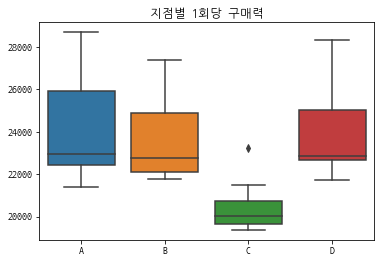

In [48]:
sns.boxplot(data = abcd_m_mean_freq)
plt.title("지점별 1회당 구매력")

## 지점별 연령에 따른 1인당 구매력 

In [74]:
A_merge = dt_A.merge(mfile, on = '회원번호', how = 'left')
A_merge.head()

,공급일자,회원번호,조합원상태_x,물품대분류,물품중분류,물품소분류,물품명,구매수량,구매금액,구매매장,...,월,요일,조합원상태_y,주소,성별,연령,배송서비스신청여부,모바일알람여부,Gold_member,연령대
0,2018-01-02,220954944,정상회원,반찬,두부/유부,두부,두부(1모:420g),1.0,3829,매장A,...,1,화,정상회원,수지구-동천동,남,51.0,미신청,수신,normal,50대
1,2018-01-02,89023040,정상회원,채소,열매채소,단호박/손질,단호박(깍뚝썰기/300g),1.0,4977,매장A,...,1,화,정상회원,분당구-구미동,여,48.0,신청,.,normal,40대
2,2018-01-02,354941440,정상회원,축산물,알,유정란,유정란/매장용(10알/국내산),1.0,7083,매장A,...,1,화,정상회원,수지구-동천동,여,50.0,미신청,.,normal,50대
3,2018-01-02,786634048,탈퇴,반찬,어묵/묵,묵,도토리묵(420g:1모),1.0,7083,매장A,...,1,화,탈퇴,수지구-동천동,여,38.0,미신청,.,normal,30대
4,2018-01-02,438543104,정상회원,축산물,알,유정란,유정란/매장용(10알/국내산),1.0,7083,매장A,...,1,화,정상회원,분당구-판교동,여,50.0,미신청,.,normal,50대


In [85]:
A_age = A_merge.pivot_table(index = ['회원번호','연령대'],values = '구매금액', aggfunc= 'sum').reset_index()
A_age

,회원번호,연령대,구매금액
0,18764160,60대이상,21059
1,20235968,60대이상,164449
2,20258240,50대,3063
3,20588608,50대,2661300
4,22259008,50대,197375
...,...,...,...
2626,1640241856,30대,9858
2627,1640596352,30대,33407
2628,1640913728,30대,16004
2629,1644557056,60대이상,27951


In [88]:
age_20 = A_age.loc[A_age.연령대 == '20대이하','구매금액']
age_30 = A_age.loc[A_age.연령대 == '30대','구매금액']
age_40 = A_age.loc[A_age.연령대 == '40대','구매금액']
age_50 = A_age.loc[A_age.연령대 == '50대','구매금액']
age_60 = A_age.loc[A_age.연령대 == '60대이상','구매금액']

In [118]:
f_result=stats.f_oneway( age_20, age_30, age_40, age_50, age_60)
f,p=f_result.statistic.round(3),f_result.pvalue.round(3)
print("One way ANOVA test")
print("F통계량:{}".format(f))
print("p-value:{}".format(p))

One way ANOVA test
F통계량:7.39
p-value:0.0


In [119]:
A_age_table = pd.DataFrame({'20대이하' : age_20, '30대' :age_30, '40대' :age_40, '50대' :age_50, '60대이상' :age_60})

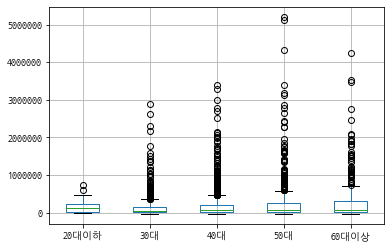

In [120]:
A_age_table.boxplot()

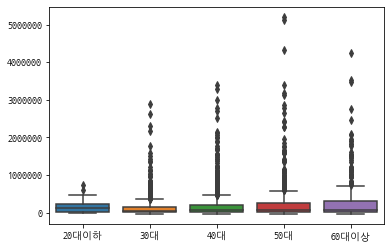

In [121]:
sns.boxplot(data = A_age_table)

In [175]:
posthoc = pairwise_tukeyhsd(A_age['구매금액'], A_age['연령대'], alpha=0.05)
print(posthoc)

      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
group1 group2   meandiff  p-adj     lower        upper    reject
----------------------------------------------------------------
 20대이하    30대 -41761.8256    0.9 -338837.0354 255313.3842  False
 20대이하    40대   5491.3085    0.9 -289393.8771  300376.494  False
 20대이하    50대  76805.8239    0.9 -219992.7921 373604.4399  False
 20대이하  60대이상  82085.5449    0.9 -216382.1702 380553.2601  False
   30대    40대   47253.134 0.2502  -16180.6876 110686.9557  False
   30대    50대 118567.6495  0.001   46762.3884 190372.9106   True
   30대  60대이상 123847.3705  0.001   45428.2783 202266.4627   True
   40대    50대  71314.5155  0.015    9188.9336 133440.0973   True
   40대  60대이상  76594.2365 0.0228    6929.7087 146258.7643   True
   50대  60대이상    5279.721    0.9  -72084.9494  82644.3914  False
----------------------------------------------------------------


In [173]:
A_age['연령대'].astype('object')

0       60대이상
1       60대이상
2         50대
3         50대
4         50대
        ...  
2626      30대
2627      30대
2628      30대
2629    60대이상
2630      30대
Name: 연령대, Length: 2631, dtype: object

In [122]:
B_merge = dt_B.merge(mfile, on = '회원번호', how = 'left')
B_age = B_merge.pivot_table(index = ['회원번호','연령대'],values = '구매금액', aggfunc= 'sum').reset_index()
age_20 = B_age.loc[B_age.연령대 == '20대이하','구매금액']
age_30 = B_age.loc[B_age.연령대 == '30대','구매금액']
age_40 = B_age.loc[B_age.연령대 == '40대','구매금액']
age_50 = B_age.loc[B_age.연령대 == '50대','구매금액']
age_60 = B_age.loc[B_age.연령대 == '60대이상','구매금액']
f_result=stats.f_oneway( age_20, age_30, age_40, age_50, age_60)
f,p=f_result.statistic.round(3),f_result.pvalue.round(3)
print("One way ANOVA test")
print("F통계량:{}".format(f))
print("p-value:{}".format(p))

One way ANOVA test
F통계량:9.544
p-value:0.0


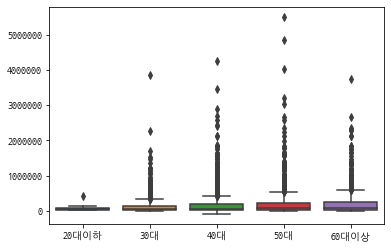

In [135]:
B_age_table = pd.DataFrame({'20대이하' : age_20, '30대' :age_30, '40대' :age_40, '50대' :age_50, '60대이상' :age_60})
sns.boxplot(data = B_age_table)

In [176]:
posthoc = pairwise_tukeyhsd(B_age['구매금액'], B_age['연령대'], alpha=0.05)
print(posthoc)

      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
group1 group2   meandiff  p-adj     lower        upper    reject
----------------------------------------------------------------
 20대이하    30대  67863.5293    0.9 -231250.4384  366977.497  False
 20대이하    40대 102671.5791 0.8716 -195270.2447 400613.4029  False
 20대이하    50대 167838.4014 0.5364  -131285.203 466962.0057  False
 20대이하  60대이상 160297.4261  0.576 -139063.6825 459658.5347  False
   30대    40대  34808.0498 0.2417  -11497.6478  81113.7475  False
   30대    50대  99974.8721  0.001   46591.1862  153358.558   True
   30대  60대이상  92433.8968  0.001   37735.0796  147132.714   True
   40대    50대  65166.8222 0.0012   18798.9173 111534.7272   True
   40대  60대이상   57625.847 0.0091    9749.7016 105501.9923   True
   50대  60대이상  -7540.9753    0.9  -62292.4646   47210.514  False
----------------------------------------------------------------


In [139]:
C_merge = dt_C.merge(mfile, on = '회원번호', how = 'left')
C_age = C_merge.pivot_table(index = ['회원번호','연령대'],values = '구매금액', aggfunc= 'sum').reset_index()
age_20 = C_age.loc[C_age.연령대 == '20대이하','구매금액']
age_30 = C_age.loc[C_age.연령대 == '30대','구매금액']
age_40 = C_age.loc[C_age.연령대 == '40대','구매금액']
age_50 = C_age.loc[C_age.연령대 == '50대','구매금액']
age_60 = C_age.loc[C_age.연령대 == '60대이상','구매금액']
f_result=stats.f_oneway( age_20, age_30, age_40, age_50, age_60)
f,p=f_result.statistic.round(3),f_result.pvalue.round(3)
print("One way ANOVA test")
print("F통계량:{}".format(f))
print("p-value:{}".format(p))

One way ANOVA test
F통계량:10.25
p-value:0.0


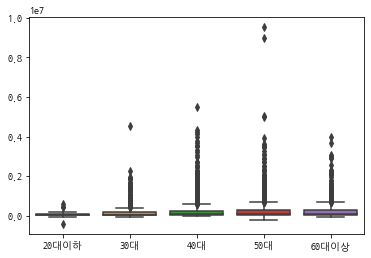

In [140]:
C_age_table = pd.DataFrame({'20대이하' : age_20, '30대' :age_30, '40대' :age_40, '50대' :age_50, '60대이상' :age_60})
sns.boxplot(data = C_age_table)

In [177]:
posthoc = pairwise_tukeyhsd(C_age['구매금액'], C_age['연령대'], alpha=0.05)
print(posthoc)

      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
group1 group2   meandiff  p-adj     lower        upper    reject
----------------------------------------------------------------
 20대이하    30대   76935.715    0.9 -190558.8158 344430.2458  False
 20대이하    40대 151895.7418 0.5202 -113847.4389 417638.9225  False
 20대이하    50대 200745.0035 0.2403  -65902.1067 467392.1136  False
 20대이하  60대이상  156230.784 0.5003 -111078.5077 423540.0756  False
   30대    40대  74960.0268  0.001   25021.8825 124898.1711   True
   30대    50대 123809.2885  0.001   69265.1642 178353.4128   True
   30대  60대이상   79295.069 0.0017   21600.7231 136989.4149   True
   40대    50대  48849.2617 0.0264    3669.8902  94028.6332   True
   40대  60대이상   4335.0422    0.9  -44601.1577  53271.2421  False
   50대  60대이상 -44514.2195 0.1566  -98142.5227   9114.0837  False
----------------------------------------------------------------


In [138]:
D_merge = dt_D.merge(mfile, on = '회원번호', how = 'left')
D_age = D_merge.pivot_table(index = ['회원번호','연령대'],values = '구매금액', aggfunc= 'sum').reset_index()
age_20 = D_age.loc[D_age.연령대 == '20대이하','구매금액']
age_30 = D_age.loc[D_age.연령대 == '30대','구매금액']
age_40 = D_age.loc[D_age.연령대 == '40대','구매금액']
age_50 = D_age.loc[D_age.연령대 == '50대','구매금액']
age_60 = D_age.loc[D_age.연령대 == '60대이상','구매금액']
f_result=stats.f_oneway( age_20, age_30, age_40, age_50, age_60)
f,p=f_result.statistic.round(3),f_result.pvalue.round(3)
print("One way ANOVA test")
print("F통계량:{}".format(f))
print("p-value:{}".format(p))

One way ANOVA test
F통계량:6.464
p-value:0.0


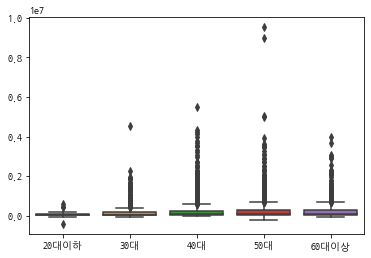

In [141]:
D_age_table = pd.DataFrame({'20대이하' : age_20, '30대' :age_30, '40대' :age_40, '50대' :age_50, '60대이상' :age_60})
sns.boxplot(data = D_age_table)

In [178]:
posthoc = pairwise_tukeyhsd(D_age['구매금액'], D_age['연령대'], alpha=0.05)
print(posthoc)

       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
group1 group2   meandiff   p-adj     lower        upper    reject
-----------------------------------------------------------------
 20대이하    30대 -146998.0229 0.8288 -541989.0604 247993.0147  False
 20대이하    40대 -118566.7279    0.9 -510058.4633 272925.0074  False
 20대이하    50대  -86176.4849    0.9 -478968.8907 306615.9209  False
 20대이하  60대이상   -22791.267    0.9 -414945.5432 369363.0091  False
   30대    40대   28431.2949 0.8327  -48481.1312  105343.721  False
   30대    50대    60821.538 0.2694  -22458.8109 144101.8868  False
   30대  60대이상  124206.7558  0.001   43990.0571 204423.4546   True
   40대    50대    32390.243 0.6296  -32289.5496  97070.0357  False
   40대  60대이상   95775.4609  0.001   35091.2139 156459.7079   True
   50대  60대이상   63385.2179  0.086   -5190.8206 131961.2563  False
-----------------------------------------------------------------


# 이상치 제거 후 ANOVA 분석

In [12]:
total4 = pd.read_csv('total4.csv')

In [13]:
mfile = pd.read_csv('mfile_model.csv')

In [14]:
dt_A = total4[total4.구매매장=='매장A']
dt_B = total4[total4.구매매장=='매장B']
dt_C = total4[total4.구매매장=='매장C']
dt_D = total4[total4.구매매장=='매장D']

In [22]:
A_merge = dt_A.merge(mfile[['회원번호', '연령대']], on = '회원번호', how = 'left')
A_age = A_merge.pivot_table(index = ['회원번호','연령대'],values = '구매금액', aggfunc= 'sum').reset_index()
age_20 = A_age.loc[A_age.연령대 == '20대이하','구매금액']
age_30 = A_age.loc[A_age.연령대 == '30대','구매금액']
age_40 = A_age.loc[A_age.연령대 == '40대','구매금액']
age_50 = A_age.loc[A_age.연령대 == '50대','구매금액']
age_60 = A_age.loc[A_age.연령대 == '60대','구매금액']
age_70 = A_age.loc[A_age.연령대 == '70대이상','구매금액']
f_result=stats.f_oneway( age_20, age_30, age_40, age_50, age_60,age_70)
f,p=f_result.statistic.round(3),f_result.pvalue.round(3)
print("One way ANOVA test")
print("F통계량:{}".format(f))
print("p-value:{}".format(p))

One way ANOVA test
F통계량:6.344
p-value:0.0


In [23]:
B_merge = dt_B.merge(mfile[['회원번호', '연령대']], on = '회원번호', how = 'left')
B_age = B_merge.pivot_table(index = ['회원번호','연령대'],values = '구매금액', aggfunc= 'sum').reset_index()
age_20 = B_age.loc[B_age.연령대 == '20대이하','구매금액']
age_30 = B_age.loc[B_age.연령대 == '30대','구매금액']
age_40 = B_age.loc[B_age.연령대 == '40대','구매금액']
age_50 = B_age.loc[B_age.연령대 == '50대','구매금액']
age_60 = B_age.loc[B_age.연령대 == '60대','구매금액']
age_70 = B_age.loc[B_age.연령대 == '70대이상','구매금액']
f_result=stats.f_oneway( age_20, age_30, age_40, age_50, age_60,age_70)
f,p=f_result.statistic.round(3),f_result.pvalue.round(3)
print("One way ANOVA test")
print("F통계량:{}".format(f))
print("p-value:{}".format(p))

One way ANOVA test
F통계량:8.461
p-value:0.0


In [24]:
C_merge = dt_C.merge(mfile[['회원번호', '연령대']], on = '회원번호', how = 'left')
C_age = C_merge.pivot_table(index = ['회원번호','연령대'],values = '구매금액', aggfunc= 'sum').reset_index()
age_20 = C_age.loc[C_age.연령대 == '20대이하','구매금액']
age_30 = C_age.loc[C_age.연령대 == '30대','구매금액']
age_40 = C_age.loc[C_age.연령대 == '40대','구매금액']
age_50 = C_age.loc[C_age.연령대 == '50대','구매금액']
age_60 = C_age.loc[C_age.연령대 == '60대','구매금액']
age_70 = C_age.loc[C_age.연령대 == '70대이상','구매금액']
f_result=stats.f_oneway( age_20, age_30, age_40, age_50, age_60,age_70)
f,p=f_result.statistic.round(3),f_result.pvalue.round(3)
print("One way ANOVA test")
print("F통계량:{}".format(f))
print("p-value:{}".format(p))

One way ANOVA test
F통계량:8.829
p-value:0.0


In [25]:
D_merge = dt_D.merge(mfile[['회원번호', '연령대']], on = '회원번호', how = 'left')
D_age = D_merge.pivot_table(index = ['회원번호','연령대'],values = '구매금액', aggfunc= 'sum').reset_index()
age_20 = D_age.loc[D_age.연령대 == '20대이하','구매금액']
age_30 = D_age.loc[D_age.연령대 == '30대','구매금액']
age_40 = D_age.loc[D_age.연령대 == '40대','구매금액']
age_50 = D_age.loc[D_age.연령대 == '50대','구매금액']
age_60 = D_age.loc[D_age.연령대 == '60대','구매금액']
age_70 = D_age.loc[D_age.연령대 == '70대이상','구매금액']
f_result=stats.f_oneway( age_20, age_30, age_40, age_50, age_60,age_70)
f,p=f_result.statistic.round(3),f_result.pvalue.round(3)
print("One way ANOVA test")
print("F통계량:{}".format(f))
print("p-value:{}".format(p))

One way ANOVA test
F통계량:6.647
p-value:0.0


In [49]:
total4.head()

,공급일자,회원번호,조합원상태,물품대분류,물품중분류,물품소분류,물품명,구매수량,구매금액,구매매장,반품_원거래일자,구매시각,월,요일
0,2018-01-02,220954944,정상회원,반찬,두부/유부,두부,두부(1모:420g),1.0,3829.0,매장A,NaN,10:32,1,화
1,2018-01-02,89023040,정상회원,채소,열매채소,단호박/손질,단호박(깍뚝썰기/300g),1.0,4977.0,매장A,NaN,10:41,1,화
2,2018-01-02,354941440,정상회원,축산물,알,유정란,유정란/매장용(10알/국내산),1.0,7083.0,매장A,NaN,11:00,1,화
3,2018-01-02,786634048,탈퇴,반찬,어묵/묵,묵,도토리묵(420g:1모),1.0,7083.0,매장A,NaN,11:28,1,화
4,2018-01-02,438543104,정상회원,축산물,알,유정란,유정란/매장용(10알/국내산),1.0,7083.0,매장A,NaN,11:59,1,화


In [57]:
store = total4.groupby(['회원번호','구매매장'])['구매매장'].count().unstack().fillna(0)
store

구매매장,매장A,매장B,매장C,매장D
회원번호,,,,
18613824,0.0,0.0,1.0,0.0
18764160,2.0,0.0,0.0,6.0
18792000,0.0,0.0,1.0,0.0
18942336,0.0,0.0,2.0,30.0
18949760,0.0,0.0,1.0,0.0
...,...,...,...,...
1644772352,0.0,2.0,0.0,0.0
1644957952,0.0,0.0,0.0,4.0
1670400000,214.0,434.0,481.0,196.0


In [64]:
store_df = pd.DataFrame(store.apply(lambda x: np.argmax(x), axis = 1), columns = ['구매매장'])

In [68]:
mfile = mfile.merge(store_df, on = '회원번호', how = 'left')
mfile

,회원번호,조합원상태,성별,연령,배송서비스신청여부,모바일알람여부,Gold_member,연령대,구매금액,구,동,연령60이상,방문횟수,연령대_4560대,구매매장
0,1000012800,1,0,58.0,0,0,0,50대,7658.0,수지구,풍덕천동,0,1,1,매장B
1,1000103744,1,0,34.0,0,0,0,30대,36948.0,처인구,고림동,0,1,0,매장C
2,1000122304,1,0,38.0,0,0,0,30대,142831.0,광주,기타,0,15,0,매장C
3,1000163136,1,0,73.0,0,0,0,70대이상,138892.0,수지구,동천동,1,4,0,매장A
4,1000281920,1,0,42.0,1,0,0,40대,632554.0,수지구,풍덕천동,0,28,1,매장C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11537,999682432,0,0,47.0,0,0,0,40대,39246.0,수지구,동천동,0,1,1,매장A
11538,999721408,1,0,43.0,0,0,0,40대,43457.0,수지구,동천동,0,2,1,매장A
11539,999738112,1,0,67.0,0,0,0,60대,152960.0,수지구,성복동,1,9,1,매장D
11540,999754816,1,0,44.0,1,0,0,40대,641334.0,수지구,상현동,0,21,1,매장B


In [69]:
mfile.to_csv('mfile_merge.csv', index = False)